In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
# Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
# Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
%config Completer.use_jedi = False
from keras.applications.xception import Xception
from keras.preprocessing import image
conv_base = Xception(weights="imagenet",include_top=False,input_shape=(299,299,3))
conv_base.summary() # input 299,299,3
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(5, activation="softmax"))

model.summary()
conv_base.trainable = False
import os
import numpy as np
base_dir = '../../dataset_action/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')
# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        target_size=(299, 299),
        batch_size=10,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=10,
        class_mode='categorical')
model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['acc'])


Using TensorFlow backend.


Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               52429056  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 73,291,821
Trainable params: 73,237,293
Non-trainable params: 54,528
_________________________________________________________________
Found 2112 images belonging to 5 classes.
Found 531 images belonging to 5 classes.


In [3]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [4]:

callbacks_list = [EarlyStopping(patience=3),ModelCheckpoint(filepath='./model.{epoch:02d}-{val_loss:.4f}.hdf5',monitor='val_loss',save_best_only=True)]
    
history = model.fit(
      train_generator,
      steps_per_epoch=200,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,callbacks=callbacks_list)

Epoch 1/100
200/200 [==============================] - 81s 407ms/step - loss: 4.6531 - acc: 0.6069 - val_loss: 0.6820 - val_acc: 0.7260
Epoch 2/100
200/200 [==============================] - 77s 386ms/step - loss: 0.7498 - acc: 0.7701 - val_loss: 0.1038 - val_acc: 0.7800
Epoch 3/100
200/200 [==============================] - 81s 406ms/step - loss: 0.6086 - acc: 0.8203 - val_loss: 0.3233 - val_acc: 0.8656
Epoch 4/100
200/200 [==============================] - 79s 397ms/step - loss: 0.4895 - acc: 0.8434 - val_loss: 0.6969 - val_acc: 0.7984
Epoch 5/100
200/200 [==============================] - 79s 393ms/step - loss: 0.4005 - acc: 0.8564 - val_loss: 0.3071 - val_acc: 0.8289


In [5]:
model.save("activate_batch_10.h5")

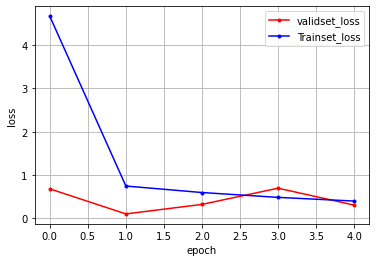

In [6]:

import matplotlib.pyplot as plt

import numpy as np
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='validset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [7]:
import pickle 


In [8]:
f = open("dog_action_img_batch_10.pkl","wb")
pickle.dump(history.history,f)
f.close()

In [5]:
import pickle 

with open('dog_action_img_batch_10.pkl', 'rb') as f:
    history = pickle.load(f)


In [7]:
history

{'val_loss': [0.681991696357727,
  0.10382381826639175,
  0.32325124740600586,
  0.6969417333602905,
  0.3071073591709137],
 'val_acc': [0.7260000109672546,
  0.7800407409667969,
  0.8655804395675659,
  0.7983706593513489,
  0.8289205431938171],
 'loss': [4.664164331633164,
  0.7469812556764627,
  0.5971326794826901,
  0.4853921768715583,
  0.4001964791397373],
 'acc': [0.6069277, 0.7700803, 0.82028115, 0.8433735, 0.8564257]}

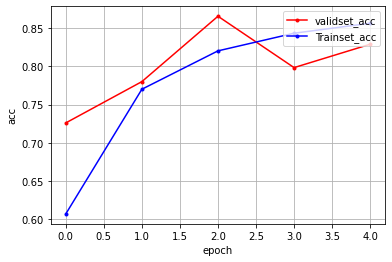

In [8]:

import matplotlib.pyplot as plt

import numpy as np
# 테스트 셋의 오차
y_vloss = history['val_acc']

# 학습셋의 오차
y_loss = history['acc']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='validset_acc')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_acc')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()